In [23]:
# Import additional dependencies
import random
import copy
import time
import matplotlib.pyplot as plt
from shapely.geometry import LineString

In [24]:
# Helper functions
def read_data(filename: str) -> (list, list):
    # Read and parse example data files
    with open('./data/' + filename) as f:
        size = list(map(int, f.readline().split(';')))
        coordinates = [list(map(int, i.split(';'))) for i in f.readlines()]
        return size, coordinates


def random_hex_color() -> str:
    # Generates random HEX color
    return '#%06X' % random.randint(0, 256 ** 3 - 1)


def line_intersect(x1, y1, x2, y2, x3, y3, x4, y4) -> bool:
    # Checks if two segments intersect each other.
    return LineString([(x1, y1), (x2, y2)]).intersects(LineString([(x3, y3), (x4, y4)]))

In [25]:
# Constans
SAVE_IMAGES = True
POPULATION_SIZE = 8
CROSSOVER_CHANCE = 0.5
MUTATION_CHANCE = 0.18
MUTATION_SEGMENT_DISTANCE = 1
MUTATION_SEGMENT_PIVOT = 2
EPOCHES = 200
LINE_DIS = 40
MAX_SEGMENTS = 4
MAX_SEGMENT_DIS = 4
COST_FUNCTION_WEIGHTS = [15, 2, 1, 10, 20]

# Dynamic variables
(field_width, field_height), coordinates = read_data('zad3.txt')

In [26]:
class Individual:
    def __init__(self):
        self.paths = []

    def __str__(self):
        return '\n'.join(str(i) for i in self.paths)

    def fitness_score(self):
        summary_distance = 0
        summary_segments = 0
        crossouts = 0
        summary_distance_outside = 0
        summary_segments_outside = 0
        
        lines = [] # Store all segments eg. [x, y, xe, ye, path]
        for path in self.paths:
            summary_segments += len(path.segments)

            x, y = path.xs, path.ys
            for seg in path.segments:
                summary_distance += seg.dis 

                xe, ye = x, y
                if seg.dir == 'U': ye -= seg.dis
                if seg.dir == 'D': ye += seg.dis
                if seg.dir == 'L': xe -= seg.dis
                if seg.dir == 'R': xe += seg.dis
                lines.append([x, y, xe, ye, path])

                for i in range(seg.dis):
                    if x <= 0 or y <= 0 or x > field_width or y > field_height: summary_distance_outside += 1
                    if seg.dir == 'U': y -= 1
                    if seg.dir == 'D': y += 1
                    if seg.dir == 'L': x -= 1
                    if seg.dir == 'R': x += 1
                
                if x <= 0 or x > field_width or y <= 0 or y >= field_height: summary_segments_outside += 1
                else:
                    if seg.dir == 'D' and y - seg.dis <= 0: summary_segments_outside += 1
                    if seg.dir == 'U' and y + seg.dis > field_height: summary_segments_outside += 1
                    if seg.dir == 'R' and x - seg.dis <= 0: summary_segments_outside += 1
                    if seg.dir == 'L' and x + seg.dis > field_width: summary_segments_outside += 1

        for i in range(len(lines) - 1):
            for j in range(i + 1, len(lines)):
                if line_intersect(*lines[i][:-1], *lines[j][:-1]):
                    crossouts += 1

        summary_distance_outside += 1 if summary_distance_outside != 0 else 0
        return sum([a * b for a, b in zip([crossouts, summary_distance, summary_segments, summary_segments_outside, summary_distance_outside], COST_FUNCTION_WEIGHTS)])


class Path:
    def __init__(self, xs=0, ys=0, xe=0, ye=0):
        self.xs = xs
        self.ys = ys
        self.xe = xe
        self.ye = ye
        self.segments = []
        self.color = random_hex_color()

    def __str__(self):
        return '(%s, %s); (%s, %s);\n' % (self.xs, self.ys, self.xe, self.ye) + '\t'.join(str(i) for i in self.segments)


class Segment:
    def __init__(self, dir='', dis=0):
        self.dir = dir
        self.dis = dis

    def __str__(self):
        return '[%s, %s]' % (self.dir, self.dis)

In [27]:
def generate_random_segments(path: Path) -> list:
    segments = []
    x, y = path.xs, path.ys
    previous_dir = None

    for i in range(random.randint(0, MAX_SEGMENTS)):
        if x == path.xe and y == path.ye: return segments

        dirs = [*'UDLR']
        if previous_dir: dirs.remove(previous_dir)
        if previous_dir == 'U': dirs.remove('D')
        if previous_dir == 'D': dirs.remove('U')
        if previous_dir == 'L': dirs.remove('R')
        if previous_dir == 'R': dirs.remove('L')

        dr = random.choice(dirs)
        ds = random.randint(1, MAX_SEGMENT_DIS)
        segment = Segment(dr, ds)
        segments.append(segment)

        if dr == 'U': y -= ds
        if dr == 'D': y += ds
        if dr == 'L': x -= ds
        if dr == 'R': x += ds
        previous_dir = dr

    segments += connect_random_segments(Path(x, y, path.xe, path.ye))
    return segments


def connect_random_segments(path) -> list:
    # If they are on the same line
    if path.xs == path.xe:
        if path.ys < path.ye: return [Segment('D', path.ye - path.ys)]
        elif path.ys > path.ye: return [Segment('U', path.ys - path.ye)]
        else: return []

    if path.ys == path.ye:
        if path.xs > path.xe: return [Segment('L', path.xs - path.xe)]
        elif path.xs < path.xe: return [Segment('R', path.xe - path.xs)]
        else: return []

    def horizontal(segment) -> None:
        segment.dir = 'R' if path.xs < path.xe else 'L'
        segment.dis = abs(path.xs - path.xe)

    def vertical(segment) -> None:
        segment.dir = 'D' if path.ys < path.ye else 'U'
        segment.dis = abs(path.ys - path.ye)

    segments = []
    previous_dir = None
    for _ in range(2):
        segment = Segment()
        if str(previous_dir) in 'UD': horizontal(segment)
        elif str(previous_dir) in 'LR': vertical(segment)
        else: 
            if random.random() > 0.5: horizontal(segment)
            else: vertical(segment)
        previous_dir = segment.dir
        segments.append(segment)

    return segments


def initial_population() -> list:
    population = []
    for _ in range(POPULATION_SIZE):
        individual = Individual()
        for [x, y, xe, ye] in coordinates:
            path = Path(x, y, xe, ye)
            path.segments = generate_random_segments(path)
            individual.paths.append(path)
        population.append(individual)
    return population



def fitness_proportionate_selection(array: list, k=1) -> Individual:
    total_fintess_score = sum([ind.fitness_score() for ind in array])
    return min(random.choices(array, [ind.fitness_score() / total_fintess_score for ind in array], k=k), key=lambda x: x.fitness_score())


def tournament_selection(array: list, k=1) -> Individual:
    return min(random.sample(array, k=k), key=lambda ind: ind.fitness_score())


# TODO: Add uniform crossover
def single_point_crossover(parent1: Individual, parent2: Individual) -> (Individual, Individual):
    # we need to replace entire path
    # parents always has the same number of paths    
    if random.random() > CROSSOVER_CHANCE: 
        return copy.deepcopy(parent1), copy.deepcopy(parent2)

    # TODO: use zip function for uniform crossover
    pivot = random.randint(1, len(parent1.paths))

    i1 = Individual()
    i2 = Individual()

    p1 = list(copy.deepcopy(path) for path in parent1.paths)
    p2 = list(copy.deepcopy(path) for path in parent2.paths)
    
    i1.paths = p1[:pivot] + p2[pivot:]
    i2.paths = p2[:pivot] + p1[pivot:]
    return i1, i2

    
def mutate(ind: Individual) -> None:
    if random.random() > MUTATION_CHANCE:
        return

    for path in ind.paths: 
        segment = random.choice(path.segments)
        idx = path.segments.index(segment)

        # Path B
        if random.random() > 0.5:
            if segment.dis > MUTATION_SEGMENT_PIVOT:
                pivot = random.randint(1, segment.dis)
                segment.dis -= pivot
                path.segments.insert(idx + 1, Segment(segment.dir, pivot))
                idx += 1
                segment = path.segments[idx]

        # Path A
        if segment.dir in 'UD':
            _dir = 'L' if random.random() >= 0.5 else 'R'
            _again_dir = 'R' if _dir == 'L' else 'L'
            _dirs = 'UD'
        else:
            _dir = 'D' if random.random() >= 0.5 else 'U'
            _again_dir = 'U' if _dir == 'D' else 'D'
            _dirs = 'LR'

        if idx > 0 and path.segments[idx - 1].dir not in _dirs:
            path.segments[idx - 1].dis += MUTATION_SEGMENT_DISTANCE * (-1 if path.segments[idx - 1].dir == _again_dir else 1)
            if path.segments[idx - 1].dis == 0:
                path.segments.pop(idx - 1)
                idx -= 1
        else:
            path.segments.insert(idx, Segment(_dir, MUTATION_SEGMENT_DISTANCE))
            idx += 1
            
        if idx < len(path.segments) - 1 and path.segments[idx + 1].dir not in _dirs:
            path.segments[idx + 1].dis += MUTATION_SEGMENT_DISTANCE * (-1 if path.segments[idx + 1].dir == _dir else 1)
            if path.segments[idx + 1].dis == 0:
                path.segments.pop(idx + 1)
        else:
            path.segments.insert(idx + 1, Segment(_again_dir, MUTATION_SEGMENT_DISTANCE))

Epoch:  0
Epoch:  20
Epoch:  40
Epoch:  60
Epoch:  80
Epoch:  100
Epoch:  120
Epoch:  140
Epoch:  160
Epoch:  180


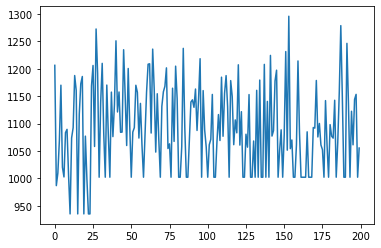

In [28]:
population = initial_population()

f = open('debug.txt', 'w')

scores = []
for j in range(EPOCHES):
    for i in range(0, len(population), 2):
        a = fitness_proportionate_selection(population, k=POPULATION_SIZE // 2)
        b = tournament_selection(population, k=POPULATION_SIZE // 2)
        
        nA, nB = single_point_crossover(a, b)

        # f.write(str(nA))

        mutate(nA)
        mutate(nB)

        # f.write('\n--------------\n')
        # f.write(str(nA))
        # f.write('\n\n')

        population.pop(0)
        population.pop(0)

        population.append(nA)
        population.append(nB)

    average_score = sum([x.fitness_score() for x in population]) / len(population)
    scores.append(average_score)

    if j % (EPOCHES // 10) == 0:
        print('Epoch: ', j)

    if average_score <= 3:
        break

f.close()
plt.plot(scores)

In [29]:
from PIL import Image
import tkinter as tk

C_WIDTH = field_width * LINE_DIS
C_HEIGHT = field_height * LINE_DIS

root = tk.Tk()
root.title('Genetic Algorithm')
root.resizable(False, False)

w = tk.Canvas(root, width=C_WIDTH, height=C_HEIGHT, bg="#505050")
w.pack()
root.update()


def draw_individual(ind: Individual) -> None:
    # Draw individual by drawing all segments for ecah path
    offset = LINE_DIS / 2
    for path in ind.paths:
        x, y = path.xs * LINE_DIS, path.ys * LINE_DIS
        for segment in path.segments:
            x_gap, y_gap = 0, 0
            if segment.dir in ('U', 'D'): y_gap = LINE_DIS
            if segment.dir in ('L', 'R'): x_gap = LINE_DIS
            
            x_sign, y_sign = 1, 1
            if segment.dir == 'U': y_sign = -1
            if segment.dir == 'L': x_sign = -1

            for i in range(segment.dis):
                w.create_line(x - offset, y - offset, x + x_gap * x_sign - offset, y - offset + y_sign * y_gap, fill=path.color) # fill='#aaa'
                if segment.dir == 'U': y -= LINE_DIS
                if segment.dir == 'D': y += LINE_DIS
                if segment.dir == 'L': x -= LINE_DIS
                if segment.dir == 'R': x += LINE_DIS


def draw_field() -> None:
    # Draw background dots
    for x in range(0, C_WIDTH, LINE_DIS):
        for y in range(0, C_HEIGHT, LINE_DIS):
            draw_rect(w, x, y, x + LINE_DIS, y + LINE_DIS, _offset=2)


def draw_rect(w, x1, y1, x2, y2, _offset=2, color='#bbb') -> None:
    # Helper function to draw a circle
    offset = LINE_DIS / _offset
    w.create_oval(x1 + offset, y1 + offset, x2 - offset, y2 - offset, fill=color, outline='')


def draw_coords() -> None:
    # Draw points by their coordinates
    for x in coordinates:
        color = random_hex_color()
        x = list(map(lambda e: (e - 1) * LINE_DIS, x))
        draw_rect(w, x[0], x[1], x[0] + LINE_DIS, x[1] + LINE_DIS, _offset=3, color=color)
        draw_rect(w, x[2], x[3], x[2] + LINE_DIS, x[3] + LINE_DIS, _offset=3, color=color)


for i, ind in enumerate(population):
    w.delete('all')

    draw_field()
    draw_individual(ind)
    draw_coords()

    if SAVE_IMAGES:
        # TODO: Save by making screen
        filename = f"models/{i}_ind"
        w.postscript(file=filename + '.ps', colormode='color')
        img = Image.open(filename + '.ps')
        img.save(filename + '.png', "png")

    # Save logs
    with open(filename + '.txt', 'w') as f:
        f.write(str(ind))

root.mainloop()